In [220]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import seaborn as sns

## Analyzing the Impact of Female Directors and Writers

To answer what impact female directors and writers have we will take our director data from WikiData and supplemented CMU movie data to see underlying trends that may be present as well as understanding the impact of female writers and directors on a movie's IMDB rating.

### Merging and Cleaning
First we will merge our two relevent datasets together.

In [122]:
movies_full = pd.read_pickle('./data/pickles/movies.p')
directors_full = pd.read_pickle('./data/pickles/director_writer_nodrop.p')

print(movies_full.columns)
print(directors_full.columns)

Index(['title', 'primaryTitle', 'originalTitle', 'wikipedia_id',
       'freebase_id_cmu', 'freebase_id_wd', 'wikidata_id', 'new_wikidata_id',
       'IMDB_id', 'mojo_id', 'release_date_cmu', 'release_date_wd',
       'release_year_cmu', 'release_year_wd', 'release_year_imdb',
       'combined_release_year', 'runtime_cmu', 'runtime_wd', 'runtime_imdb',
       'combined_runtime', 'box_office_cmu', 'box_office_wd', 'languages',
       'countries', 'averageRating_imdb', 'numVotes_imdb', 'genres_cmu',
       'genres_imdb', 'directors', 'writers'],
      dtype='object')
Index(['title', 'movie_wiki_id', 'movie_wikidata_id', 'movie_freebase_id',
       'movie_imdb_id', 'role', 'imdb_id', 'wikidata_id', 'name', 'gender',
       'birth', 'height', 'ethnicity'],
      dtype='object')


There are many columns that are not relevant to the analysis to be done and therefore we will create a new DataFrame for both the movies and directors that have the columns to be analyzed.

In [123]:
movies = movies_full[[
    'title',
    'freebase_id_cmu',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu'
]].copy()

print(f'The length of the dataset is {len(movies)}, the number of freebase IDs is {len(movies.freebase_id_cmu.notna())}')
movies.genres_cmu = movies.genres_cmu.apply(lambda x: eval(x))
movies.head()

The length of the dataset is 81741, the number of freebase IDs is 81741


,title,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu
0,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'}


In [124]:
directors = directors_full[[
    'title',
    'movie_freebase_id',
    'movie_imdb_id',
    'role',
    'name',
    'imdb_id',
    'wikidata_id',
    'gender',
    'birth',
    'height',
    'ethnicity'
]]
directors.head()

,title,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height,ethnicity
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN,NaN
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN,NaN
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN,NaN


The data will be merged on the movie freebase ID

In [125]:
directors_movies_merge = pd.merge(left=directors, right=movies, how='left', 
                                    left_on='movie_freebase_id', right_on='freebase_id_cmu')

directors_movies_merge.head()

,title_x,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height,ethnicity,title_y,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN,NaN,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN,NaN,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN,NaN,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN,NaN,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN,NaN,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'}


After merging the dataset will need some cleaning before it can be analyzed.

In [126]:
print(all(directors_movies_merge.title_x == directors_movies_merge.title_y)) #are title_x and title_y are exactly the same?
directors_movies = directors_movies_merge[[
    'title_x',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu',
    'movie_freebase_id',
    'movie_imdb_id',
    'imdb_id',
    'role',
    'name',
    'gender',
    'birth',
    'height',
    'ethnicity'
]].copy()

directors_movies.head()

True


,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN


The birth dates are stored as strings. For our analysis we will be using the birth year to obtain an "age at movie release" column so that we can also see how the success of directors and writers may change over their career.

In [127]:
directors_movies['birth_year'] = directors_movies.birth.apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else x)
directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0


In [128]:
print(f'There are {len(directors_movies[directors_movies.combined_release_year.isna()])} NaN values in the combined release year column')
print(f'There are {len(directors_movies[directors_movies.birth_year.isna()])} NaN values in the birth year column')

There are 10672 NaN values in the combined release year column
There are 93750 NaN values in the birth year column


In [129]:
#create a column to store age at release values
directors_movies['age_at_release'] = np.nan

#fill in with actual values of age at release year if there is both a release year and a birth year
for indx, row in directors_movies.loc[directors_movies.combined_release_year.notna() & directors_movies.birth_year.notna()].iterrows():
    directors_movies.loc[indx,'age_at_release'] = row.combined_release_year- row.birth_year

directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0,37.0


The genre data is currently stored as a dictionary with the the freebase ID as the key and the genre as the value. Let's change this to just a list of genres per movie.

In [130]:
print(f'There are {len(directors_movies[directors_movies.genres_cmu.isna()])} NaN values in the genres_cmu column')

There are 0 NaN values in the genres_cmu column


In [131]:
directors_movies.genres_cmu = directors_movies.genres_cmu.apply(lambda x: list(x.values()))

Lastly for the ease of analysis some of the column names will be changed/shortened.

In [132]:
directors_movies.rename(mapper={
    'title_x': 'title',
    'combined_runtime':'runtime',
    'combined_release_year':'release_year',
    'averageRating_imdb':'rating',
    'genres_cmu':'genres',
    'numVotes_imdb':'num_votes'    
},inplace=True, axis=1)
directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"[Mystery, Biographical film, Drama, Crime Drama]",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"[Crime Fiction, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,[Drama],/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0,37.0


In [197]:
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,240073.000000,238079.000000,234845.000000,2.348450e+05,156995.000000,151865.000000
mean,1975.814415,94.538418,6.300630,1.263893e+04,1928.575878,44.278728
std,28.596344,90.933387,1.149018,6.790405e+04,30.220792,15.218229
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,-48.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1982.000000,93.000000,6.400000,5.870000e+02,1929.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,51.000000
max,2022.000000,14400.000000,10.000000,2.648879e+06,2005.000000,1999.000000


Looks like we need to do a little bit of cleaning on the age_at_release column. The assumption is being made that children are not able to work as directors or writers and we will remove age at release values that are less than 18 and the oldest acting film director was Manoel de Oliveira who worked until he was approximately 99. In general we can assume that values this high could be outliers

In [201]:
directors_movies.age_at_release=directors_movies.age_at_release.apply(lambda x: np.nan if x<18 else (np.nan if x> 99 else x))
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,240073.000000,238079.000000,234845.000000,2.348450e+05,156995.000000,148841.000000
mean,1975.814415,94.538418,6.300630,1.263893e+04,1928.575878,44.043819
std,28.596344,90.933387,1.149018,6.790405e+04,30.220792,11.631462
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1982.000000,93.000000,6.400000,5.870000e+02,1929.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,50.000000
max,2022.000000,14400.000000,10.000000,2.648879e+06,2005.000000,99.000000


### Analysis

#### General

Before getting too deep into the analysis it should be understood what is in the data and what is missing from the data. We can first understand what director data was able to be collected. how many movies have complete director and writer data, how many movies have at least one director or writer present and how many directors and writers are present for each gender.

In [202]:
dirs = directors_movies[directors_movies.role == 'director']
writers = directors_movies[directors_movies.role == 'writer']
dir_num_tot = dirs.imdb_id.nunique()
wri_num_tot = writers.imdb_id.nunique()
uniq_dirs = dirs.drop_duplicates(subset='imdb_id', keep='first')
uniq_wris = writers.drop_duplicates(subset='imdb_id', keep='first')
full_dirs = uniq_dirs.dropna(subset=['gender', 'name', 'birth'])
full_wris = uniq_wris.dropna(subset=['gender', 'name', 'birth'])

print(f'Out of {len(directors_movies)} rows of data:')
print(f'There are {len(dirs)} number of directors and {len(writers)} number of writers.')
print(f'There are {dir_num_tot} number of unique directors and {wri_num_tot} number of unique writers.')
print(f'\nOut of all of the unique directors {len(uniq_dirs[uniq_dirs.name.notna()])} have a name, {len(uniq_dirs[uniq_dirs.gender.notna()])} have a gender, {len(uniq_dirs[uniq_dirs.height.notna()])} have a height, {len(uniq_dirs[uniq_dirs.ethnicity.notna()])} have an ethnicity, and {len(uniq_dirs[uniq_dirs.birth_year.notna()])} have a birth year.')
print(f'\nOut of all of the unique writers {len(uniq_wris[uniq_wris.name.notna()])} have a name, {len(uniq_wris[uniq_wris.gender.notna()])} have a gender, {len(uniq_wris[uniq_wris.height.notna()])} have a height, {len(uniq_wris[uniq_wris.ethnicity.notna()])} have an ethnicity, and {len(uniq_wris[uniq_wris.birth_year.notna()])} have a birth year.')
print(f'\nFor this analysis height and ethinicity will not be considered due to lack of complete data')
print(f'Out of all of the directors there are {len(full_dirs)} with complete gender, name, and birth data')
print(f'Out of all of the writers there are {len(full_wris)} with complete gender, name, and birth data')

Out of 250745 rows of data:
There are 86474 number of directors and 164271 number of writers.
There are 29028 number of unique directors and 60785 number of unique writers.

Out of all of the unique directors 21204 have a name, 18743 have a gender, 130 have a height, 91 have an ethnicity, and 16783 have a birth year.

Out of all of the unique writers 25969 have a name, 24298 have a gender, 171 have a height, 143 have an ethnicity, and 22087 have a birth year.

For this analysis height and ethinicity will not be considered due to lack of complete data
Out of all of the directors there are 16654 with complete gender, name, and birth data
Out of all of the writers there are 21997 with complete gender, name, and birth data


Let's see how many movies are present that have a complete set of directors and writers that have at least gender information

In [203]:
movie_groups = directors_movies.groupby('movie_freebase_id')

for fb_id, movie in tqdm(movie_groups):
    all_data = True
    indices = []
    for indx, row in movie.iterrows():
        indices.append(indx)
        if row.gender != 'male' and row.gender!= 'female':
            all_data = False
    directors_movies.loc[indices,'all_crew'] = all_data
    

100%|██████████| 74200/74200 [00:43<00:00, 1692.61it/s]


In [204]:
full_crew = directors_movies[directors_movies.all_crew == True]
print(f'Out of {directors_movies.movie_freebase_id.nunique()}, there are {directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()} movies that have at least one director or writer with gender data')
print(f'and there are {full_crew.movie_freebase_id.nunique()} movies with full crew gender data.')
print(f'This is means that {round(directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)*100}% have at least one point of gender data and {100*round(full_crew.movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)}% of the movies have full crew gender data.')

Out of 74200, there are 66755 movies that have at least one director or writer with gender data
and there are 27382 movies with full crew gender data.
This is means that 89.97% have at least one point of gender data and 36.9% of the movies have full crew gender data.


It would also be interesting to see how many people there is at least gender data for that have worked as both directors and writers.

In [205]:
both_dir_writer = directors_movies.dropna(subset='gender').groupby('imdb_id').role.nunique()
print(f'There are {len(both_dir_writer[both_dir_writer>1])} number of people who have gender data that have worked as both a director and writer.')

There are 12691 number of people who have gender data that have worked as both a director and writer.


From the above analysis we can see that in general there is a lot of data available for analysis on gender and still a significant portion of data available with gender data on the full crew. There is also more complete data on a larger percentage of the directors than for the writers and there are many people who work as both a writer and a director.

Now that we have an understanding of the number of data points that are present. the data can start to be analyzed for trends. To start the data set can be split into male writers/directors and female writers/directors and analyzed.

#### Looking at the Difference Between Genders at Large

The data can be divided by role and gender to start an exploratory analysis into what trends may exist within the data

In [257]:
male_dir = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'director')]
male_writer = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'writer')]
female_dir = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'director')]
female_writer = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'writer')]

male_dir.describe()


,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,64316.000000,63114.000000,61922.000000,6.192200e+04,63267.000000,60182.000000
mean,1974.199468,93.060367,6.319620,1.235680e+04,1928.950132,43.925576
std,29.027748,69.186642,1.120251,6.527563e+04,30.636233,10.814958
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000
25%,1952.000000,78.000000,5.700000,1.370000e+02,1904.000000,36.000000
50%,1980.000000,93.000000,6.400000,5.920000e+02,1930.000000,43.000000
75%,2001.000000,107.000000,7.100000,2.774750e+03,1954.000000,50.000000
max,2022.000000,9360.000000,9.700000,2.648879e+06,2005.000000,99.000000


In [259]:
female_dir.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,3411.000000,3499.000000,3541.000000,3541.000000,3271.000000,2971.000000
mean,1995.489592,91.058874,6.520418,8019.574979,1951.999389,42.945473
std,18.305299,36.113077,1.062280,36854.270301,23.148688,10.793738
min,1896.000000,1.000000,1.600000,5.000000,1872.000000,18.000000
25%,1991.000000,81.000000,5.900000,155.000000,1945.000000,35.000000
50%,2002.000000,93.000000,6.600000,595.000000,1956.000000,42.000000
75%,2007.000000,105.000000,7.200000,2662.000000,1967.000000,50.000000
max,2019.000000,763.000000,9.400000,842297.000000,2000.000000,99.000000


In [260]:
male_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,83125.000000,83436.000000,81806.000000,8.180600e+04,81525.000000,77335.000000
mean,1973.338346,95.777374,6.343832,1.764436e+04,1927.181711,44.262675
std,27.611012,46.672009,1.068824,8.192645e+04,29.530843,12.194018
min,1894.000000,0.000000,1.000000,5.000000e+00,1622.000000,18.000000
25%,1951.000000,82.000000,5.800000,1.750000e+02,1904.000000,36.000000
50%,1976.000000,94.000000,6.500000,7.760000e+02,1926.000000,42.000000
75%,1999.000000,108.000000,7.100000,3.892750e+03,1952.000000,51.000000
max,2022.000000,4875.000000,9.500000,2.648879e+06,2005.000000,99.000000


In [261]:
female_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,8875.000000,9070.000000,8775.000000,8.775000e+03,8482.000000,7925.000000
mean,1975.377465,93.644432,6.383442,1.426396e+04,1929.538081,43.383722
std,31.188012,34.041105,0.982049,7.095991e+04,32.235211,12.298462
min,1896.000000,1.000000,1.000000,5.000000e+00,1855.000000,18.000000
25%,1945.000000,80.000000,5.900000,2.200000e+02,1899.000000,35.000000
50%,1987.000000,93.000000,6.500000,8.220000e+02,1932.000000,41.000000
75%,2004.000000,106.000000,7.000000,3.819000e+03,1958.000000,50.000000
max,2022.000000,822.000000,9.400000,1.851387e+06,2000.000000,99.000000


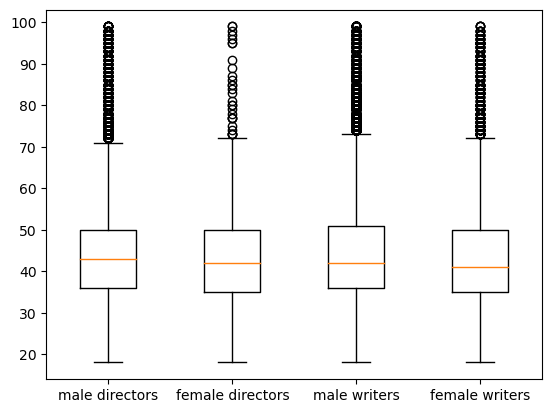

In [256]:

plt.boxplot([male_dir.age_at_release.dropna(), 
    female_dir.age_at_release.dropna(), 
    male_writer.age_at_release.dropna(), 
    female_writer.age_at_release.dropna()],
    showfliers=None,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
None


From the above plot it can be seen that in general the age range for directors and writers is consistent between men and women

Text(37.597222222222214, 0.5, 'male director age')

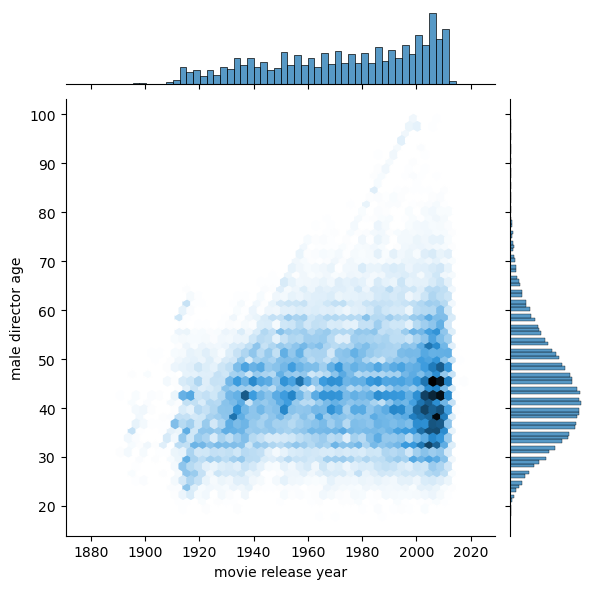

In [229]:
sns.jointplot(x='release_year', y='age_at_release', data=male_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male director age')

Text(37.597222222222214, 0.5, 'female director age')

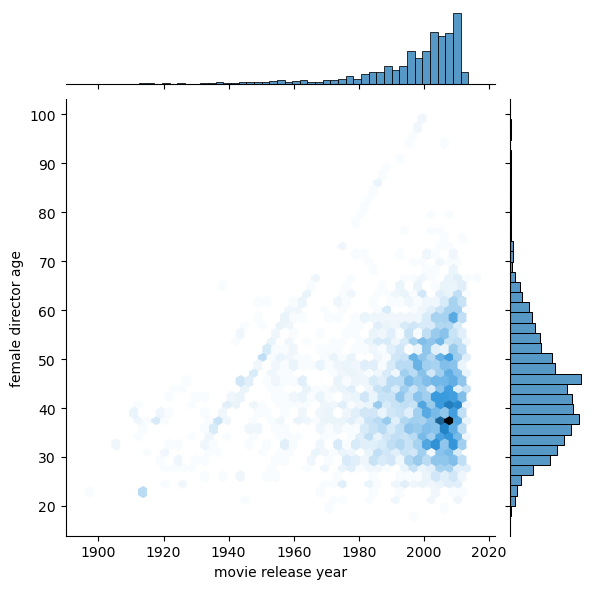

In [230]:
sns.jointplot(x='release_year', y='age_at_release', data=female_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female director age')

Text(37.597222222222214, 0.5, 'male writer age')

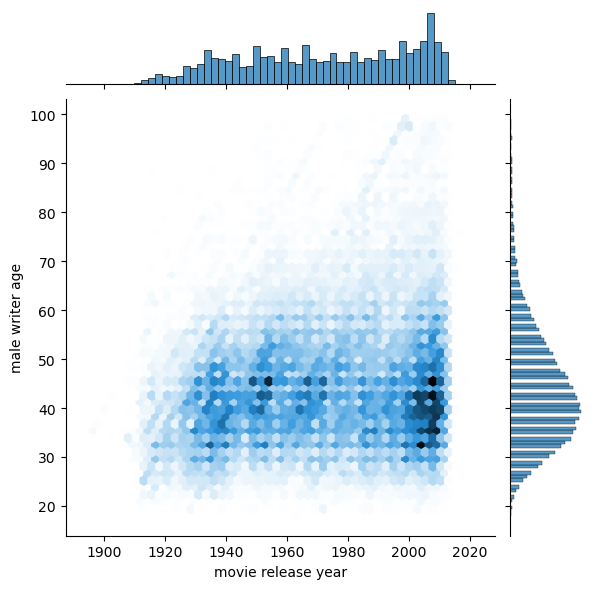

In [232]:
sns.jointplot(x='release_year', y='age_at_release', data=male_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male writer age')

Text(37.597222222222214, 0.5, 'female writer age')

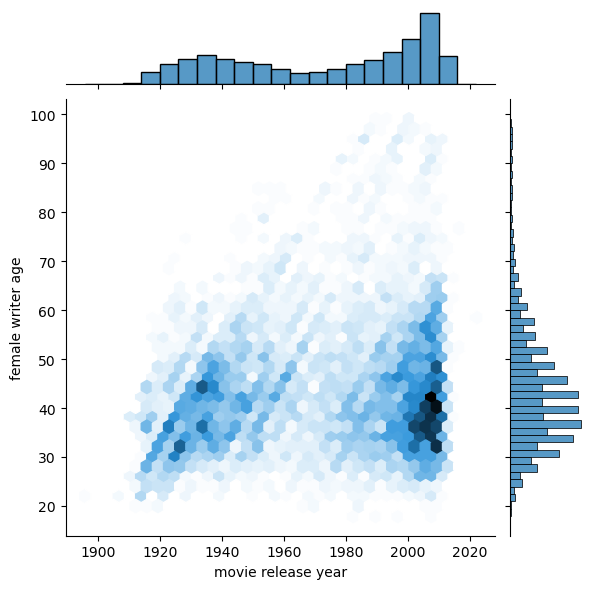

In [233]:
sns.jointplot(x='release_year', y='age_at_release', data=female_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female writer age')

From the above graphs we can see that in general the age of  male writers and directors has been fairly consistent throughout the time period in the CMU dataset, but it can be seen that there is a large increase in the amount of female directors past 1980 and a bimodal distribution of female writers.

Next the number of directors and writers will be analyzed.

Text(0.5, 0, 'female writers')

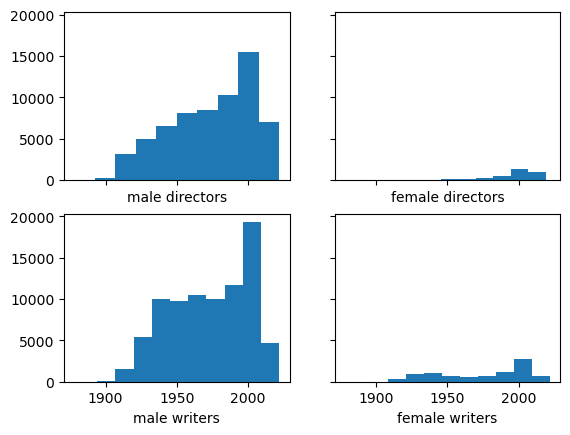

In [237]:
fig, ax = plt.subplots(2,2, sharex= True, sharey= True)
ax[0,0].hist(male_dir.release_year)
ax[0,1].hist(female_dir.release_year)
ax[1,0].hist(male_writer.release_year)
ax[1,1].hist(female_writer.release_year)
ax[0,0].set_xlabel('male directors')
ax[0,1].set_xlabel('female directors')
ax[1,0].set_xlabel('male writers')
ax[1,1].set_xlabel('female writers')


From the above histrograms it can be seen that the number of female directors and writers that took part in movies compared to male directors and writers.

Text(0.5, 0, 'movie release year')

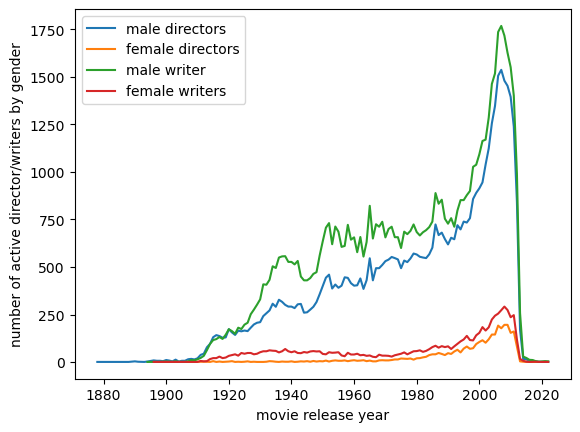

In [254]:
year_num_male_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_male_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_female_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()
year_num_female_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()

plt.plot(year_num_male_dir, label='male directors')
plt.plot(year_num_female_dir, label='female directors')
plt.plot(year_num_male_wri, label='male writer')
plt.plot(year_num_female_wri, label='female writers')
plt.legend()
plt.ylabel('number of active director/writers by gender')
plt.xlabel('movie release year')


From the above inital analysis it can be seen that the age at release and movie ratings for male and female movie directors and writes are very similar although the number of males to females in the movie industry behind the behind is siginificantly different with their being much less female directors and writers.

#### Looking at Director and Writer Breakdown per Movie

Now that trends at large have been analyzed the effect of female team members for individual movies can be looked into. For this analysis the data usedw will only include movies that have complete team member data.

First does having more women on a movie's creative team lead to a higher IMDB rating?

In [286]:
rating_by_fperc = pd.DataFrame()
rating_by_fperc['percent_female'] = full_crew.groupby('movie_freebase_id').apply(
    lambda x: len(x[x.gender == 'female'])/len(x))

rating_by_fperc['rating'] = full_crew.groupby('movie_freebase_id').rating.unique()
print(f'Is there only one unique rating value per movie? {all(rating_by_fperc.rating.apply(lambda x: len(x)) == 1)}')
rating_by_fperc['rating'] = rating_by_fperc['rating'].apply(lambda x: x[0])
rating_by_fperc['release_year'] = full_crew.groupby('release_year').rating.unique()

Is there only one unique rating value per movie? True


<AxesSubplot:xlabel='percent_female', ylabel='rating'>

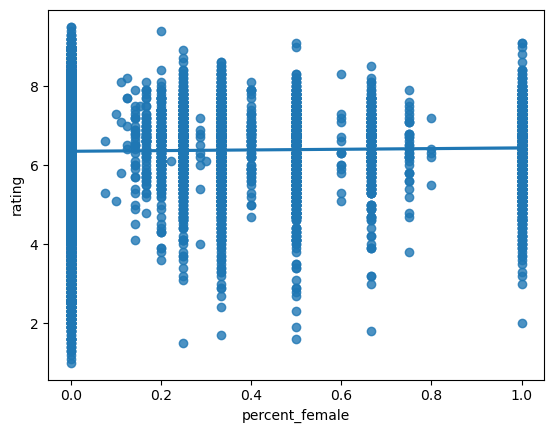

In [281]:
sns.regplot(data=rating_by_fperc, x='percent_female', y='rating')

In [298]:
year_by_fperc = pd.DataFrame()
year_by_fperc = pd.merge(left=rating_by_fperc, right=full_crew[['release_year', 'movie_freebase_id']], how='left', left_on=rating_by_fperc.index, right_on='movie_freebase_id' )
year_by_fperc.drop('release_year_x', inplace=True, axis=1)
year_by_fperc.rename(mapper = {'release_year_y':'release_year'}, axis=1, inplace=True)
year_by_fperc.head()

,percent_female,rating,release_year,movie_freebase_id
0,0.0,8.1,1928.0,/m/011_mj
1,0.0,8.1,1928.0,/m/011_mj
2,0.0,8.1,1993.0,/m/011x_4
3,0.0,8.1,1993.0,/m/011x_4
4,0.0,8.1,1993.0,/m/011x_4


In [327]:
year_by_fperc_avg=pd.DataFrame()
year_by_fperc_avg['percent_female_avg'] = year_by_fperc.groupby('release_year').percent_female.mean()
year_by_fperc_avg['rating_avg'] = year_by_fperc.groupby('release_year').rating.mean()
year_by_fperc_avg['number_of_titles'] = year_by_fperc.groupby('release_year').movie_freebase_id.count()
print(year_by_fperc_avg.describe())
#get rid of years that only have a few data points
old_num_titles = year_by_fperc_avg.number_of_titles.sum()
year_by_fperc_avg = year_by_fperc_avg[year_by_fperc_avg.number_of_titles>50]
new_num_titles = year_by_fperc_avg.number_of_titles.sum()

print(f'There were a total of {old_num_titles-new_num_titles} titles removed from the list')
print(f'This represented {round((old_num_titles-new_num_titles)/old_num_titles,4)*100}% of the data')


       percent_female_avg  rating_avg  number_of_titles
count          123.000000  122.000000        123.000000
mean             0.069137    6.291438        596.796748
std              0.049321    0.327780        461.774818
min              0.000000    5.042105          2.000000
25%              0.038803    6.225578        285.000000
50%              0.062500    6.376843        587.000000
75%              0.093232    6.479613        774.000000
max              0.333333    7.100000       1952.000000
There were a total of 212 titles removed from the list
This represented 0.29% of the data


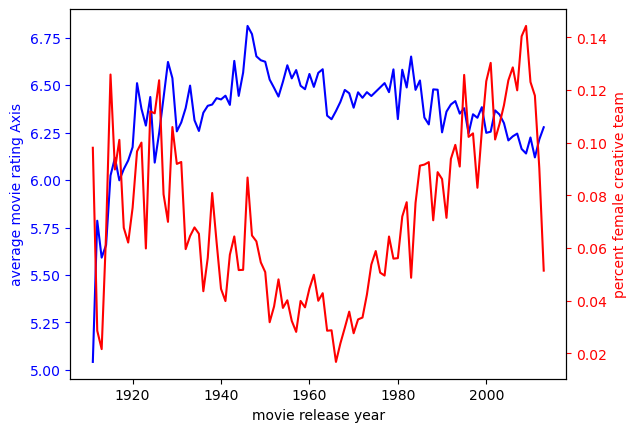

In [328]:
fig, ax = plt.subplots()

ax.plot(year_by_fperc_avg.index, year_by_fperc_avg.rating_avg, color='blue')
ax.set_ylabel('average movie rating Axis', color="blue")        # set y axis title to blue
ax.tick_params(axis='y', colors="blue")       # set y axis tick labels to blue
ax.set_xlabel('movie release year')

ax2 = ax.twinx()
ax2.plot(year_by_fperc_avg.index, year_by_fperc_avg.percent_female_avg, color='red')
ax2.set_ylabel('percent female creative team', color="red")        # set y axis title to red
ax2.tick_params(axis='y', colors="red")       # set y axis tick labels to red
